# Описание проекта

**Цель**: необходимо разработать модель, которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды. Модель обучается на данных с параметрами добычи и очистки. 

**Задачи**: 
1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Описание данных

<center><font size=3.5><b>Технологический процесс</b></font>:</center>

| Feature | Description |
| --- | --- |
| Rougher feed | исходное сырье|
| Rougher additions | флотационные реагенты |
| Rougher process | флотация |
| Rougher tails | отвальные хвосты |
| Float banks | флотационная установка |
| Cleaner process | очистка |
| Rougher Au | черновой концентрат золота |
| Final Au | финальный концентрат золота |

<br>
<center><font size=3.5><b>Флотационные реагенты</b></font>:</center>

| Addition name | Description |
| --- | --- |
| Xanthate | ксантогенат (промотер, или активатор флотации) |
| Sulphate | сульфат (на данном производстве сульфид натрия) |
| Depressant | депрессант (силикат натрия) |

<br>
<center><font size=3.5><b>Параметры этапов</b></font>:</center>

| Stage name | Description |
| --- | --- |
| air amount | объём воздуха |
| fluid levels | уровень жидкости |
| feed size | размер гранул сырья |
| feed rate | скорость подачи |

# Подготовка данных

In [1]:
# подключаем все необходимые библиотеки
import os
import pandas as pd
from scipy.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Union, List

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from IPython.display import clear_output

In [2]:
# задаем стили и размер графиков
sns.set(style='darkgrid', rc={'figure.figsize': (9, 6)})

## Загрузка данных и ознакомление с ними

In [3]:
# путь до директории с файлами
file_path = '/datasets/'

# меняем директорию
try:
    # на сервере
    os.chdir(file_path)
except FileNotFoundError:
    # на локальном компьютере
    os.chdir(f'.{file_path}')

In [4]:
# загружаем все датасеты
full_df = pd.read_csv('gold_industry_full.csv')
train_df = pd.read_csv('gold_industry_train.csv')
test_df = pd.read_csv('gold_industry_test.csv')

In [5]:
# посмотрим основную информацию по полному датасету
full_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


In [6]:
print(f'Размер обучающей выборки: {train_df.shape[0]} x {train_df.shape[1]}')
print(f'Размер тестовой выборки: {test_df.shape[0]:6} x {test_df.shape[1]}')

Размер обучающей выборки: 14579 x 87
Размер тестовой выборки:   4860 x 53


В тестовой выборке гораздо меньше колонок, чем в обучающей.

In [7]:
# переведем колонку date в тип datetime в каждом датасете и зададим ее в качестве индекса
dfs = [full_df, train_df, test_df]  # dfs[.] ссылается на те же объекты, что и full_df, train_df, test_df, это не копии

# сделаем колонку date индексом в рассматриваемых датафреймах 
for df in dfs:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

In [8]:
print('Число полностью дублирующихся строк:', full_df.duplicated().sum())

Число полностью дублирующихся строк: 0


In [9]:
# выведем колонки в которых есть пропуски
dfs_nans = [df.isna().sum() for df in dfs]

print(
    pd.DataFrame({name: val[val > 0] for name, val in zip(['full', 'train', 'test'], dfs_nans)})\
    .fillna(0).astype('int').to_markdown()
)

|                                                    |   full |   train |   test |
|:---------------------------------------------------|-------:|--------:|-------:|
| final.output.concentrate_ag                        |      1 |       1 |      0 |
| final.output.concentrate_pb                        |      1 |       1 |      0 |
| final.output.concentrate_sol                       |    211 |     192 |      0 |
| final.output.tail_ag                               |      1 |       1 |      0 |
| final.output.tail_pb                               |    101 |      75 |      0 |
| final.output.tail_sol                              |      6 |       5 |      0 |
| primary_cleaner.input.depressant                   |     37 |      28 |      9 |
| primary_cleaner.input.sulfate                      |     24 |      23 |      1 |
| primary_cleaner.input.xanthate                     |    104 |      61 |     43 |
| primary_cleaner.output.concentrate_pb              |    116 |      88 |      0 |
| pr

В некоторых случаях `full != train + test`, это относится к тем колонкам, которые не представлены в тестовой выборке.
Данные по сути своей - временные ряды, т.е. мы можем заполнить пропуски при помощи интерполяции. 

In [10]:
# заполняем пропуски при помощи линейной интерполяции, кроме тестовой выборки
for df in dfs[:-1]:
    df.interpolate(inplace=True)

## Проверка правильности расчетов recovery

In [11]:
# проверим правильность расчетов показателя эффективности обогащения
# для начала создадим функцию для расчета

def recovery(C: Union[float, pd.Series], 
             F: Union[float, pd.Series], 
             T: Union[float, pd.Series]) -> Union[float, pd.Series]:
    """
    Расчет эффективности обогащения золотосодержащей руды
    
    Parameters
    ----------
    C: Union[float, pd.Series] 
        доля золота в концентрате после флотации/очистки
    F: Union[float, pd.Series] 
        доля золота в сырье/концентрате до флотации/очистки
    T: Union[float, pd.Series] 
        доля золота в отвальных хвостах после флотации/очистки
        
    Returns
    ----------
    recovery: pd.Series 
        показатель эффективности обогащения в процентах
    """
    return C * (F - T) / F / (C - T) * 100

In [12]:
# показатель recovery после флотации
calc_rougher_recovery = recovery(train_df['rougher.output.concentrate_au'], 
                                 train_df['rougher.input.feed_au'], 
                                 train_df['rougher.output.tail_au'])

In [13]:
# показатель recovery после всего процесса обогащения
calc_final_recovery = recovery(train_df['final.output.concentrate_au'], 
                               train_df['rougher.input.feed_au'], 
                               train_df['final.output.tail_au']).fillna(0)

In [14]:
print('Средняя абсолютная ошибка между представленными данными и расчетами')
print('после флотации:   {:.2e}'.format(mean_absolute_error(train_df['rougher.output.recovery'], calc_rougher_recovery)))
print('после обогащения: {:.2e}'.format(mean_absolute_error(train_df['final.output.recovery'], calc_final_recovery)))

Средняя абсолютная ошибка между представленными данными и расчетами
после флотации:   1.09e-14
после обогащения: 9.22e-15


Значения ошибок крайне незначительны, представленные данные верны.

## Анализ признаков в обучающей и тестовой выборках

In [15]:
# выведем названия признаков, которые не входят в тестовую выборку
cols_in_train_only = set(train_df.columns) - set(test_df.columns)
cols_in_train_only

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Эти колонки отображают признаки, которые были рассчитаны или измерены после завершения технологического процесса, данные признаки не будем использовать при обучении.

In [16]:
# разделим данные на таргет (y) и обучающую (X) части
# указанные выше колонки не войдут в обучающие выборки
y_train_final = train_df['final.output.recovery']
X_train_final = train_df.drop(cols_in_train_only, axis=1)
X_test_final = test_df.copy(deep=True)

# при обучении модели для предсказания recovery после флотаци будем использовать только те признаки
# которые идут до стадии первой очистки (до колонки 22)
y_train_rougher = train_df['rougher.output.recovery']
X_train_rougher = train_df.iloc[:, :22]
X_test_rougher = test_df.iloc[:, :22]

In [17]:
# значения recovery для теста возьмем из full_df
y_test_final = full_df.loc[X_test_final.index, 'final.output.recovery']
y_test_rougher = full_df.loc[X_test_rougher.index, 'rougher.output.recovery']

In [18]:
print('Проверяем размерности')
for name, dfs in zip(['Rougher', 'Final'], [(y_train_final, X_train_final, X_test_final, y_test_final), 
                                            (y_train_rougher, X_train_rougher, X_test_rougher, y_test_rougher)]):
    print(f'\n{name} target train shape:  ', dfs[0].shape)
    print(f'{name} features train shape:', dfs[1].shape)
    print(f'{name} target test shape:   ', dfs[3].shape)
    print(f'{name} features test shape: ', dfs[2].shape)

Проверяем размерности

Rougher target train shape:   (14579,)
Rougher features train shape: (14579, 52)
Rougher target test shape:    (4860,)
Rougher features test shape:  (4860, 52)

Final target train shape:   (14579,)
Final features train shape: (14579, 22)
Final target test shape:    (4860,)
Final features test shape:  (4860, 22)


In [19]:
# соберем данные в словари
rougher_train = {'X': X_train_rougher, 'y': y_train_rougher}
final_train = {'X': X_train_final, 'y': y_train_final}

## Промежуточный вывод

- загружены все необходимые данные
- предоставленные расчеты показателя `recovery` после флотации и после процесса обогащения верны
- из обучающей выборки исключены признаки, которые получают и расчитывают после процесса обогащения (знание о будущем)
- проведена первичная обработка данных

# Анализ данных

## Концентрация металлов на различных этапах

In [20]:
stage_names = {
            'rougher.input.feed':                 'сырьё',
            'rougher.output.concentrate':         'черновой концентрат',
            'primary_cleaner.output.concentrate': 'концентрат после 1й очистки',
            'final.output.concentrate':           'финальный концентрат'
        }

def plot_concentrate_dists(df: pd.DataFrame, cols: List[str], renamed: bool = False) -> None:
    """
    Построить распределения концентраций металла на различных этапах.
    
    Parameters
    ----------
    df: pf.DataFrame
        датафрейм, содержащий значения концентраций металла(-ов) на различных стадиях
    cols: List[str]
        названия колонок, для которых необходимо построить распределение
    renamed: bool, default(False)
        были ли переименованы исходные колонки
    """
    
    metal = cols[0].rsplit('_', 1)[1].title()
    labels = [col.rsplit('_', 1)[0] for col in cols]
    
    if not renamed:
        labels = [stage_names[label] for label in labels]
        
    labels = iter(labels)
    colors = iter(plt.get_cmap('Set2').colors)
    
    for col in cols:
        median = df[col].median()
        color = next(colors)
        
        sns.histplot(df, x=col, label=next(labels), kde=True, color=color)
        plt.text(median, 100, s=f'{median:.1f}%', backgroundcolor='white', ha='center', c=color)
        
    plt.title(f'Концентрация {metal} на различных стадиях')
    plt.xlabel('Относительная концентрация, %')
    
    plt.legend()
    plt.show()

In [21]:
# создадим словарь, в котором будут списки с названиями колонок, относящиеся только к одному металлу
concentrates = {}
metals = ['au', 'pb', 'ag']

for metal in metals:
    concentrates[metal.title()] = [col for col in train_df.columns 
                                   if f'concentrate_{metal}' in col or f'feed_{metal}' in col]

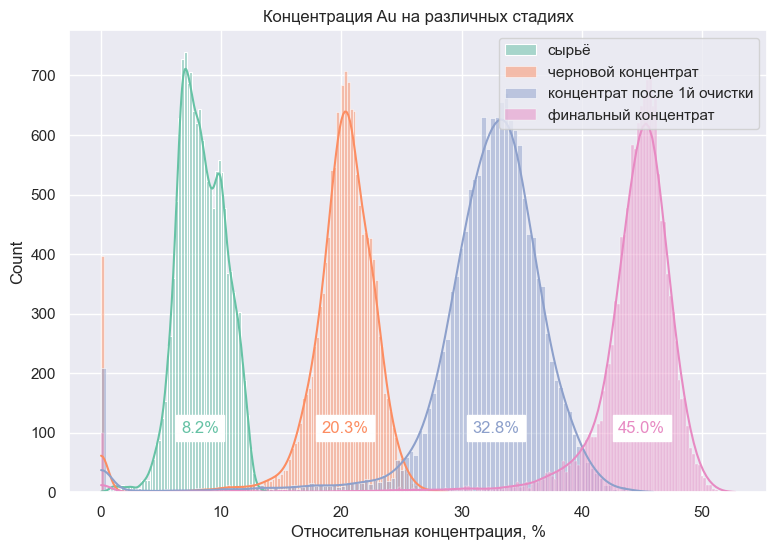

In [22]:
plot_concentrate_dists(train_df, concentrates['Au']);

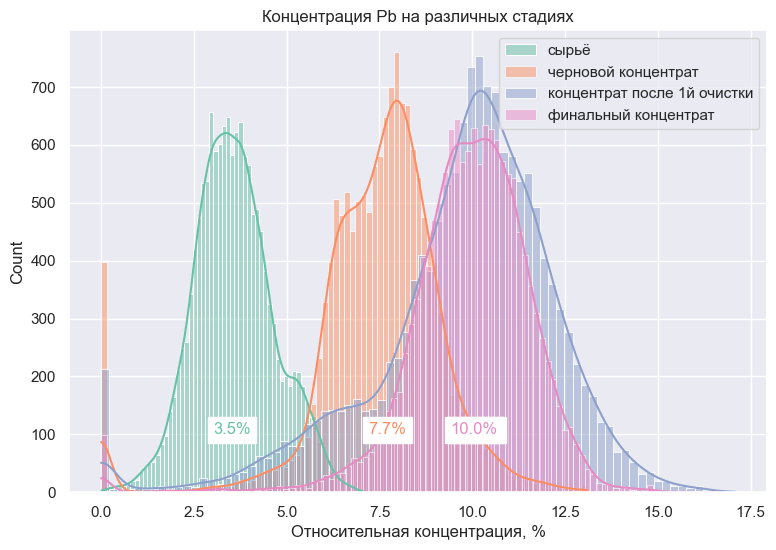

In [23]:
plot_concentrate_dists(train_df, concentrates['Pb']);

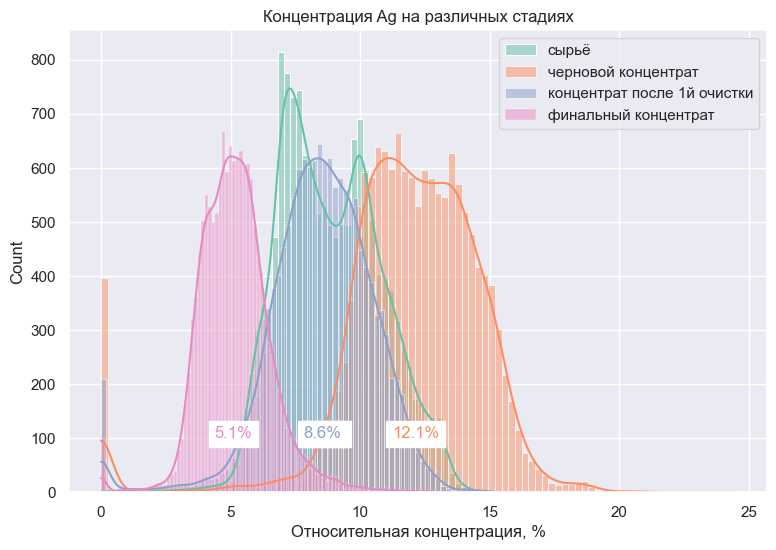

In [24]:
plot_concentrate_dists(train_df, concentrates['Ag']);

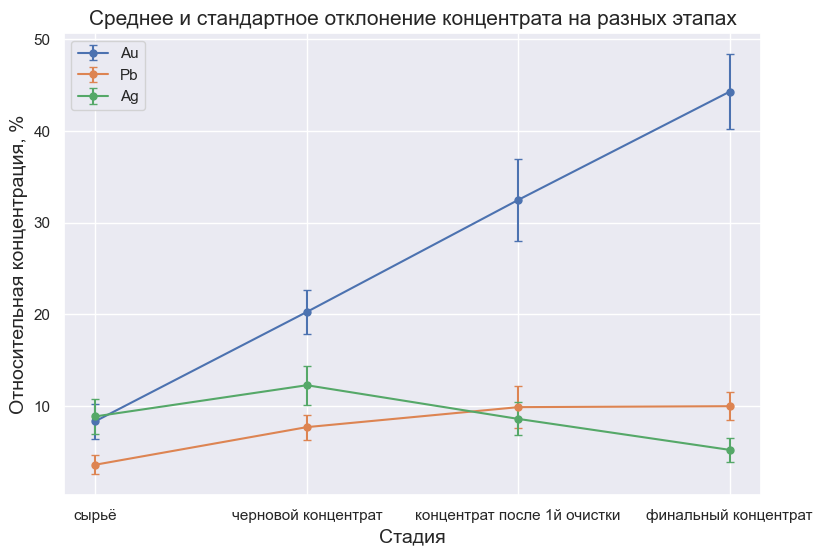

In [25]:
# построим изменение значений средних и стандартных отклонений для распределений на разных этапах

for metal, cols in concentrates.items():
    # исключим выбросы около нуля для более правильного расчета mean и std
    sub_df = train_df[train_df[cols] > 1][cols]
    sub_df.columns = [stage_names[col.rsplit('_', 1)[0]] for col in sub_df.columns]
    mean_vals = sub_df.mean()
    stds = sub_df.std()

    plt.errorbar(mean_vals.index, mean_vals, stds, label=metal, marker='o', ms=5, capsize=3)

plt.title('Среднее и стандартное отклонение концентрата на разных этапах', fontdict={'size': 15})
plt.ylabel('Относительная концентрация, %', fontdict={'size': 14})
plt.xlabel('Стадия', fontdict={'size': 14})

plt.legend()
plt.show()

На каждом этапе относительная концентрация золота растет (что и требуется), причем зависимость строго линейная. Концентрация свинца также возрастает до второй очистки, после которой в финальном концентрате не изменяется. Более сложная зависимость у серебра: в черновом концентрате его доля возрастает, затем после первой очистки становится приблизительно равной изначальной доле и уменьшается в финальном концентрате.

## Сравнение распределений размеров гранул

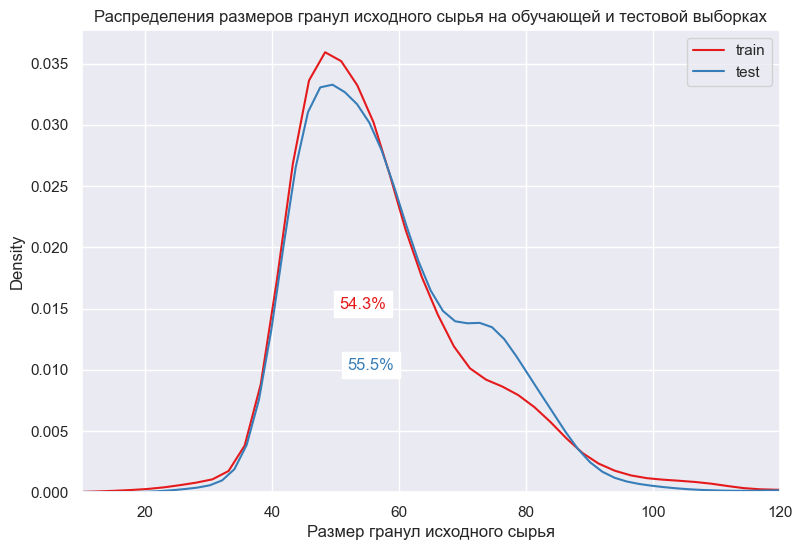

In [26]:
col_rougher_size = 'rougher.input.feed_size'  # название колонки с размерами гранул исходного сырья
colors = iter(plt.get_cmap('Set1').colors)
start_y = 0.02

for name, df in {'train': train_df, 'test': test_df}.items():
    median = df[col_rougher_size].median()
    color = next(colors)
    
    sns.kdeplot(data=df, x=col_rougher_size, label=name, color=color)
    plt.text(median, start_y:=start_y-0.005, s=f'{median:.1f}%', backgroundcolor='white', ha='center', c=color)

# для удобства исключим из рассмотрения большие выбросы
plt.xlim([10, 120])

plt.title('Распределения размеров гранул исходного сырья на обучающей и тестовой выборках')
plt.xlabel('Размер гранул исходного сырья')

plt.legend()
plt.show()

Распределения схожи между собой, медианные значения отличаются незначительно. С распределениями всё в порядке.

Проверим гипотезу о равенстве двух средних для рассматриваемых выборок.

$H_0$: средние распределений равны<br>
$H_1$: средние распределений не равны

In [27]:
p_val = ttest_ind(train_df[col_rougher_size], test_df[col_rougher_size].dropna()).pvalue

if p_val < 0.05:
    print('Значения средних не равны')
else:
    print('Значения средних равны')

Значения средних равны


## Суммарная концентрация металлов

In [28]:
# создадим датафрейм с суммарной концентрацией металлов на каждом этапе
sum_concentrates = pd.DataFrame(
    {
        f'{col}_металлов': train_df[[f'{col}_{m}' for m in metals]].sum(1) for col in stage_names
    }
)

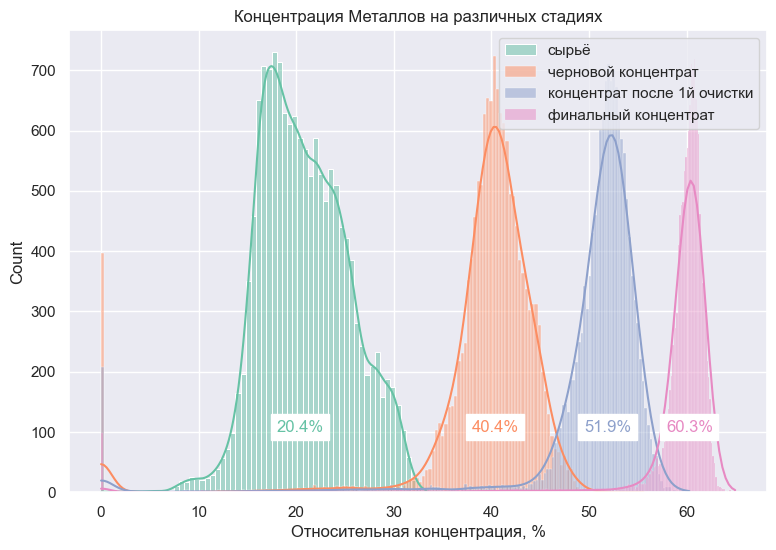

In [29]:
# построим распределения
plot_concentrate_dists(sum_concentrates, sum_concentrates.columns)

Суммарная относительная концентрация металлов растет с каждым этапом, разброс значений уменьшается.  

## Распределения `recovery`

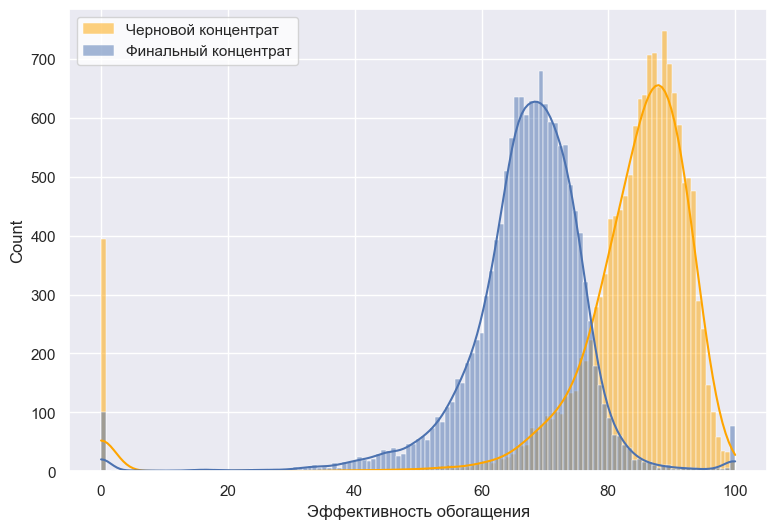

In [30]:
sns.histplot(train_df, x='rougher.output.recovery', label='Черновой концентрат', color='orange', kde=True)
sns.histplot(train_df, x='final.output.recovery', label='Финальный концентрат', kde=True)

plt.legend(facecolor='white')
plt.xlabel('Эффективность обогащения');

Оба распределения близки к нормальному со скосом влево. Эффективность обогащения после флотации выше, чем после всего процесса восстановления золота. Наблюдается большое число значений `recovery`, равных 0 или 100. В реальности вероятность получить подобные значения крайне мала, это похоже на выбросы. При обучении моделей будем исключать эти данные из рассмотрения, однако итоговый скор будем расчитывать со всеми доступными данными.

In [31]:
# предположим, что если удалить выбросы только по условию на таргетный признак 0 < recovery < 100
# то их также не будет во всех признаках (всё взаимосвязано)

for data in [rougher_train, final_train]:
    condition = (data['y'] > 0) & (data['y'] < 100)
    data['X'] = data['X'][condition]
    data['y'] = data['y'][condition]

In [32]:
# проверим наше предположение (в признаках нет выбросов)
((final_train['X'] == 0) & (final_train['X'] == 100)).sum()

rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
rougher.input.floatbank11_sulfate       

Всё отлично, можно приступать к обучению моделей.

# Построение и обучение модели

Создадим все необходимые функции для расчета метрик и проведения обучения моделей с подбором гиперпараметров и кросс-валидацией. Напомним как проходит кросс-валидация.


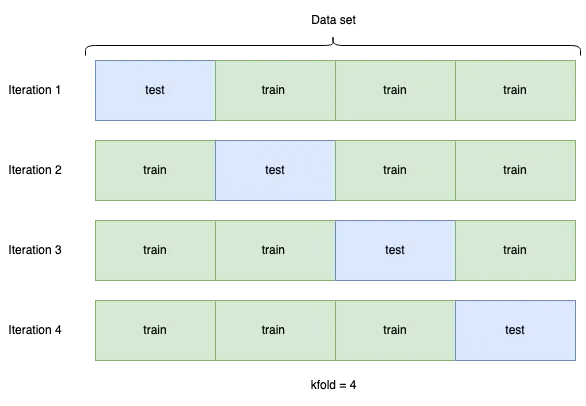

In [33]:
def symmetric_mape(true, predicted):
    """
    Расчет симметричного среднего абсолютного процентного отклонения.
    
    Parameters:
    ----------
    true: ndarray или series
        истинные значения целевого признака
    predicted: ndarray или series
        предсказанные значения целевого признака
        
    Returns:
    --------
    loss: float, np.ndarray[float]
        значение метрики
    """
    in_sum = abs(true - predicted) / (abs(true) + abs(predicted))
    
    return 2 * 100 / len(true) * in_sum.sum()

In [34]:
def final_smape(rougher_smape, final_smape, frac_final=0.75):
    """
    Расчет итогового симметричного среднего абсолютного процентного отклонения.
    
    Parameters:
    ----------
    rougher_smape: float, np.ndarray[float]
        значение sMAPE, рассчитанное для эффективности обогащения чернового концентрата
    final_smape: float, np.ndarray[float]
        значение sMAPE, рассчитанное для эффективности обогащения финального концентрата
    frac_final: float [0, 1]
        доля значения sMAPE для финального концентрата в расчете итогового sMAPE
        
    Returns:
    -------
    loss: float
        значение метрики
    """
    
    return (1 - frac_final) * rougher_smape + frac_final * final_smape

In [35]:
def train_cv(estimator, parameters, rougher_data, final_data):
    """
    Обучение модели с подбором гиперпараметров и кросс-валидацией
    
    Parameters:
    ----------
    estimator: (BaseEstimator)
        модель, которую необходимо обучить
    parameters: dict
        словарь со значениями гиперпараметров модели
    rougher_data: dict[array-like]
        данные X, y для флотации
    final_data: dict[array-like]
        данные X, y для всего процесса обогащения
    clean_train: bool
        если True, из данных при обучении будут исключены значения recovery, равные 0 или 100
    
    Returns:
    -------
    models: dict[OptunaSearchCV]
        обученные модели для предсказания recovery после флотации и после всего процесса обогащения
    """
    models = {}
    
    for name, data in zip(['rougher', 'final'], [rougher_data, final_data]):
        y = data['y'] 
        X = data['X']         
            
        models[name] = OptunaSearchCV(estimator, parameters,
                                      refit=True,
                                      random_state=101,
                                      scoring=make_scorer(symmetric_mape, greater_is_better=False),
                                      timeout=120,
                                      n_jobs=-1,
                                      verbose=10,
                                      cv=3)
    
        models[name].fit(X, y)
    
    return models

In [36]:
def plot_train_results(y_true, y_predicted, title, ind, rows=2, cols=2):
    """
    Построение зависимостей predict(true) и recovery(date) для обученной модели
    
    Parameters:
    ----------
    y_true: array-like
        истинные значения recovery
    y_predicted: array-like
        предсказанные моделью значения recovery
    title: str
        название модели (rougher или final)
    ind: int
        индекс строки
    rows: int
        число строк
    cols: int
        число колонок
    """
    xy_labels = iter([('True value', 'Predictred value'), ('Date', 'Recovery')])
    xy_vals = iter([(y_true, y_predicted, y_true, y_true), 
                    (y_true.index, y_predicted, y_true.index, y_true)])
    
    for i in range(ind-1, ind+1):
        xy_label = next(xy_labels)
        xy_val = next(xy_vals)
        
        plt.subplot(rows, cols, i)
        plt.plot(*xy_val[:2], 'o', label=f'Predicted', alpha=0.6, markersize=4,)
        plt.plot(*xy_val[2:], 'ro', label=f'True', alpha=0.6, markersize=4)

        plt.legend(loc=4, facecolor='white')
        plt.title(title)
        plt.xlabel(xy_label[0])
        plt.ylabel(xy_label[1])

In [37]:
def train_pipeline(estimator, 
                   parameters, 
                   rougher_data, 
                   final_data, 
                   print_info=True, 
                   plot_res=True):
    
    """
    Провести обучение двух моделей (для предсказания recovery после флотации и после всего процесса обогащения),
    вывести основные результаты обучения.
    
    Parameters:
    ----------
    estimator: (BaseEstimator)
        модель, которую необходимо обучить
    parameters: dict
        словарь со значениями гиперпараметров модели
    rougher_data: dict[array-like]
        данные X, y для флотации
    final_data: dict[array-like]
        данные X, y для всего процесса обогащения
    clean_train: bool (default=True)
        если True, из данных при обучении будут исключены значения recovery, равные 0 или 100
    print_info: bool (default=True)
        вывести лучшие гиперпараметры, sMAPE каждой модели и final sMAPE
    plot_res: bool (default=True)
        вывести зависимости predict(true) и recovery(date) для обученных моделей
    
    Returns:
    -------
    models: dict[OptunaSearchCV]
        обученные модели для предсказания recovery после флотации и после всего процесса обогащения
    """
    
    models = train_cv(estimator, parameters, rougher_data, final_data)
    name_model_data = list(zip(models.items(), [rougher_data, final_data]))
    
    if print_info:
        for (name, model), data in name_model_data:
            print(f'\n{name.title()} model')
            
            print('\nBest parameters:')
            for param, val in model.best_params_.items():
                if isinstance(val, str):
                    print(f'    {param}: {val}')
                else:
                    print(f'    {param}: {val:.4f}')
            print(f'Best score:      {-model.best_score_:.2e}\n')
        
        f_smape = -final_smape(models['rougher'].best_score_, models['final'].best_score_)
        print('\nFinal sMAPE:', '{:.2e}'.format(f_smape))

    if plot_res:
        i = 0
        plt.figure(figsize=(15, 12))
        
        for (name, model), data in name_model_data:
            y_true = data['y']
            y_predicted = model.predict(data['X'])
            plot_train_results(y_true, y_predicted, f'{name.title()} model', i:=i+2)
        
        plt.show()
            
    return models, f_smape

## Линейные модели

Обучим несколько линейных моделей: Lasso, Ridge, LinearRegression.

C:\Users\Sergei\AppData\Local\Temp\ipykernel_11220\356207244.py:29: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  models[name] = OptunaSearchCV(estimator, parameters,
[I 2023-05-12 13:45:15,434] A new study created in memory with name: no-name-72417334-0207-4723-99cd-6bec3479a1ef
[I 2023-05-12 13:45:15,435] Searching the best hyperparameters using 14182 samples...
[I 2023-05-12 13:45:15,770] Trial 3 finished with value: -6.567390139215263 and parameters: {'regressor__alpha': 0.23104386532551402, 'regressor__positive': True}. Best is trial 3 with value: -6.567390139215263.
[I 2023-05-12 13:45:15,774] Trial 0 finished with value: -6.689854777652425 and parameters: {'regressor__alpha': 0.014284055009214572, 'regressor__positive': True}. Best is trial 3 with value: -6.567390139215263.
[I 2023-05-12 13:45:15,800] Trial 5 finished with value: -7.639150142774409 and parameters: {'regressor__alpha': 1.9607685842288183, '


Rougher model

Best parameters:
    regressor__alpha: 0.2310
    regressor__positive: 1.0000
Best score:      6.57e+00


Final model

Best parameters:
    regressor__alpha: 0.7938
    regressor__positive: 0.0000
Best score:      9.20e+00


Final sMAPE: 8.54e+00


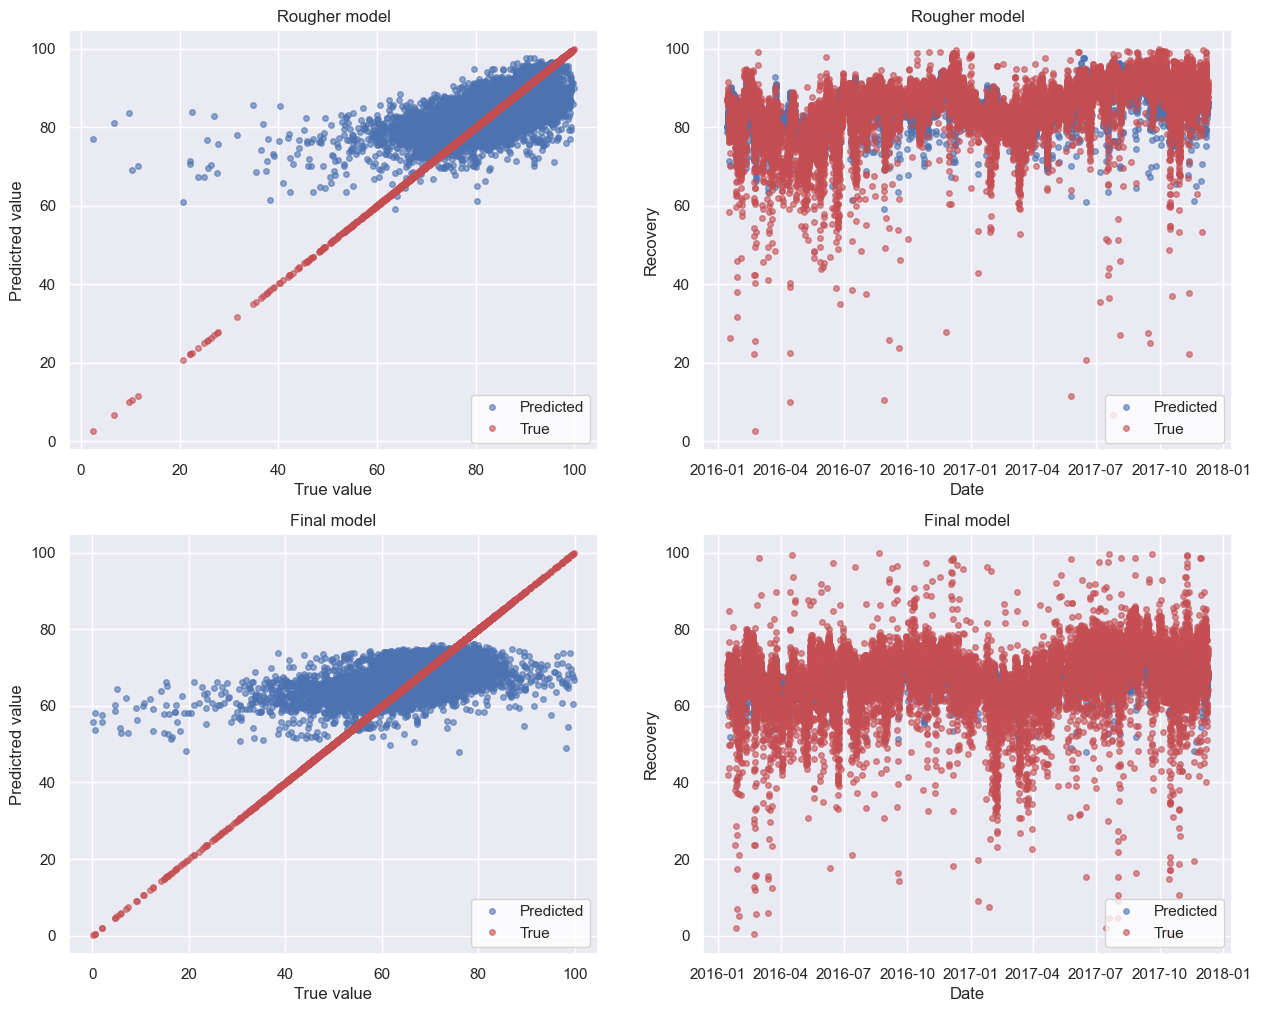

In [38]:
linear_lasso, llasso_smape = train_pipeline(
    Pipeline(
        [
            ('scaler', StandardScaler()),
            ('regressor', Lasso(random_state=101))
        ]
    ), 
    {
        'regressor__alpha': FloatDistribution(0.01, 10, log=True),
        'regressor__positive': CategoricalDistribution([True, False])
    },
    rougher_train, 
    final_train
)

C:\Users\Sergei\AppData\Local\Temp\ipykernel_11220\356207244.py:29: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  models[name] = OptunaSearchCV(estimator, parameters,
[I 2023-05-12 13:45:17,972] A new study created in memory with name: no-name-75cfd1d4-559c-4663-92e3-4b0558e050cc
[I 2023-05-12 13:45:17,973] Searching the best hyperparameters using 14182 samples...
[I 2023-05-12 13:45:18,233] Trial 0 finished with value: -7.571751345292339 and parameters: {'regressor__alpha': 0.1292068440662413, 'regressor__solver': 'cholesky'}. Best is trial 0 with value: -7.571751345292339.
[I 2023-05-12 13:45:18,260] Trial 9 finished with value: -7.564229136912192 and parameters: {'regressor__alpha': 0.9926021811416081, 'regressor__solver': 'cholesky'}. Best is trial 9 with value: -7.564229136912192.
[I 2023-05-12 13:45:18,265] Trial 1 finished with value: -7.572441578358043 and parameters: {'regressor__alpha': 0.05076478310185


Rougher model

Best parameters:
    regressor__alpha: 0.9926
    regressor__solver: cholesky
Best score:      7.56e+00


Final model

Best parameters:
    regressor__alpha: 0.9367
    regressor__solver: lsqr
Best score:      1.10e+01


Final sMAPE: 1.01e+01


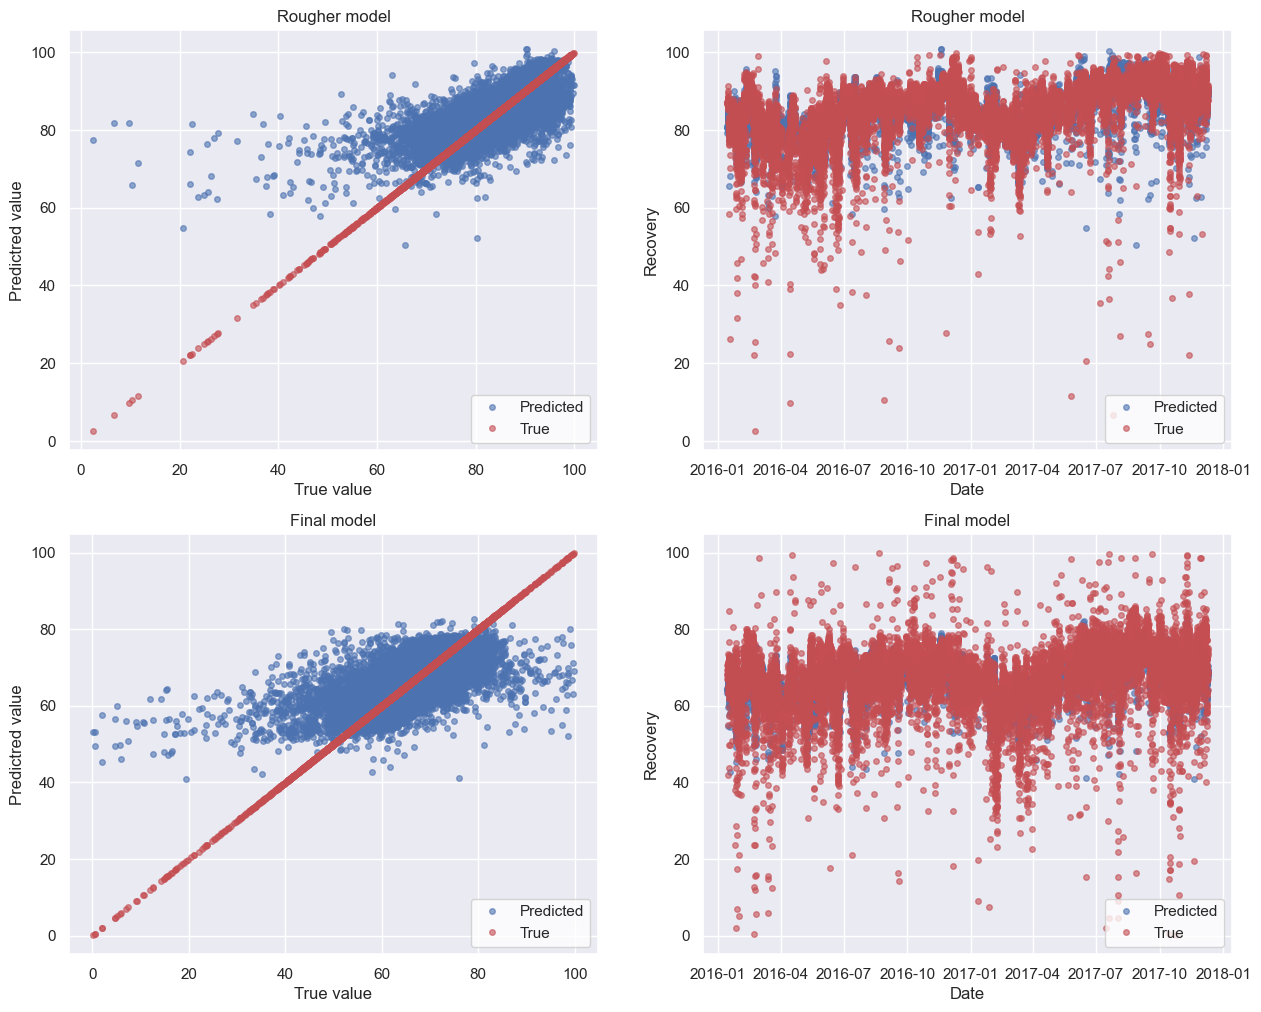

In [39]:
linear_ridge, lridge_smape = train_pipeline(
    Pipeline(
        [
            ('scaler', StandardScaler()),
            ('regressor', Ridge(random_state=101))
        ]
    ), 
    {
        'regressor__alpha': FloatDistribution(0.01, 1, log=True),
        'regressor__solver': CategoricalDistribution(['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    },
    rougher_train, 
    final_train
)

C:\Users\Sergei\AppData\Local\Temp\ipykernel_11220\356207244.py:29: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  models[name] = OptunaSearchCV(estimator, parameters,
[I 2023-05-12 13:45:28,155] A new study created in memory with name: no-name-2e2b1d61-37b7-404d-a6ef-5ae4ebf44343
[I 2023-05-12 13:45:28,156] Searching the best hyperparameters using 14182 samples...
[I 2023-05-12 13:45:28,632] Trial 0 finished with value: -7.572888875603791 and parameters: {'regressor__positive': False}. Best is trial 0 with value: -7.572888875603791.
[I 2023-05-12 13:45:28,638] Trial 4 finished with value: -6.7007607554271145 and parameters: {'regressor__positive': True}. Best is trial 4 with value: -6.7007607554271145.
[I 2023-05-12 13:45:28,640] Trial 3 finished with value: -6.7007607554271145 and parameters: {'regressor__positive': True}. Best is trial 4 with value: -6.7007607554271145.
[I 2023-05-12 13:45:28,643] Trial 1 finis


Rougher model

Best parameters:
    regressor__positive: 1.0000
Best score:      6.70e+00


Final model

Best parameters:
    regressor__positive: 1.0000
Best score:      9.52e+00


Final sMAPE: 8.81e+00


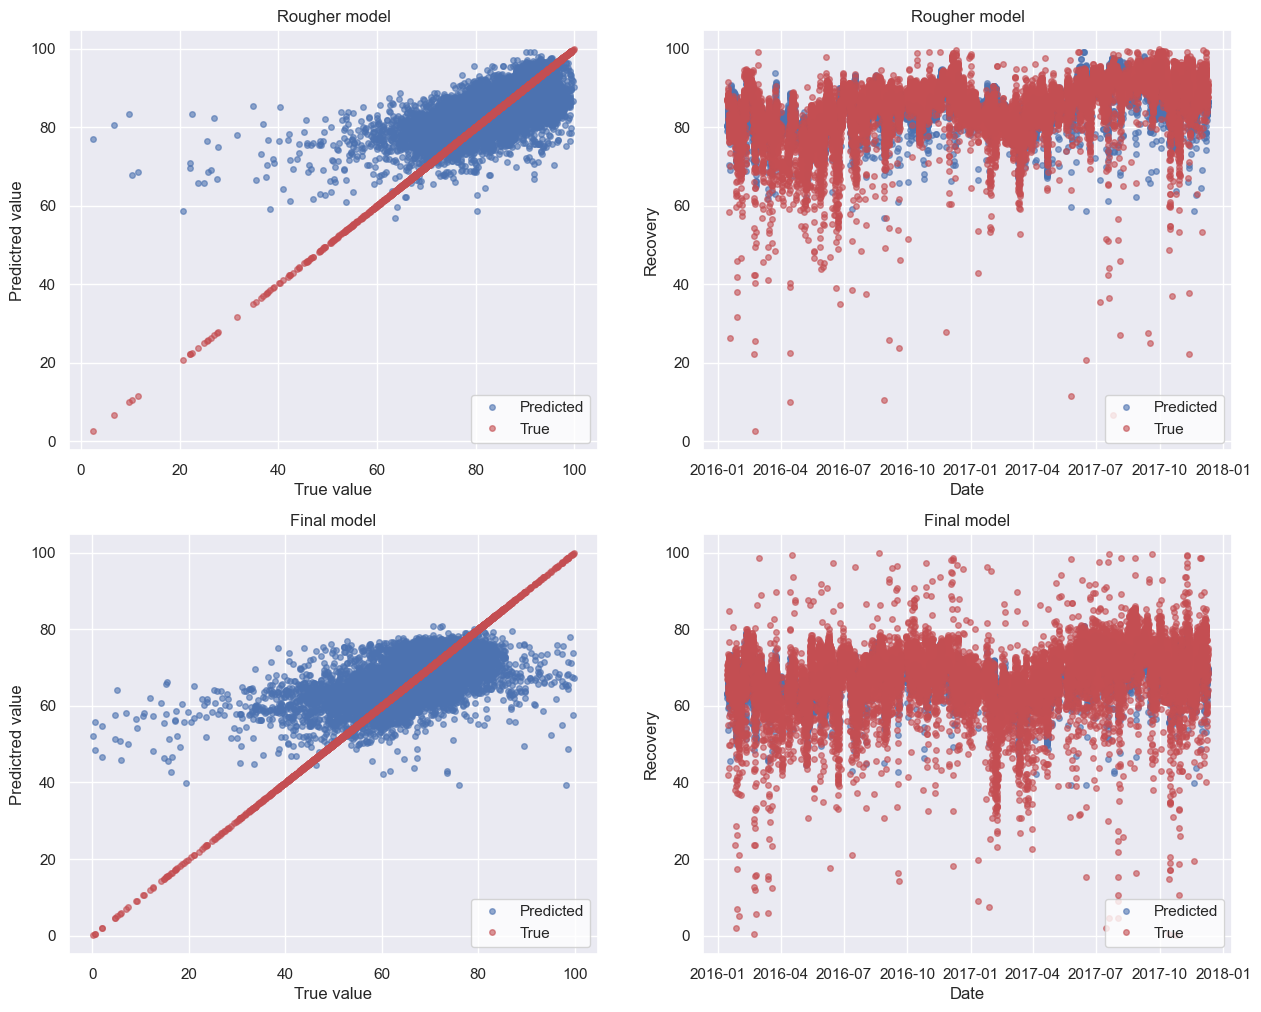

In [40]:
linear_reg, lreg_smape = train_pipeline(
    Pipeline(
        [
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]
    ), 
    {
        'regressor__positive': CategoricalDistribution([True, False])
    },
    rougher_train, 
    final_train
)

In [41]:
# соберем все обученные модели в список
trained_models = [linear_lasso, linear_ridge, linear_reg]

# запишем все метрики для моделей в датафрейм
f_smape_train = pd.DataFrame(
    {
        'sMAPE черновой': [-model['rougher'].best_score_ for model in trained_models],
        'sMAPE итоговый': [-model['final'].best_score_ for model in trained_models],
        'final_sMAPE':    [llasso_smape, lridge_smape, lreg_smape]
    },
    index=['Lasso', 'Ridge', 'LinReg']
)
f_smape_train

,sMAPE черновой,sMAPE итоговый,final_sMAPE
Lasso,6.567390,9.198888,8.541013
Ridge,7.564229,11.011747,10.149867
LinReg,6.700761,9.515221,8.811606


Лучшей моделью на данный момент на обучающей выборке является Lasso.

## Градиентный бустинг

In [43]:
cb_reg= CatBoostRegressor(random_state=101, iterations=1000, verbose=0)

cb_reg = train_cv(cb_reg, {}, rougher_train, final_train)

C:\Users\Sergei\AppData\Local\Temp\ipykernel_11220\356207244.py:29: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  models[name] = OptunaSearchCV(estimator, parameters,
[I 2023-05-12 13:45:31,091] A new study created in memory with name: no-name-5bbb1213-95b8-4d70-bb67-b0b97a235f93
[I 2023-05-12 13:45:31,091] Searching the best hyperparameters using 14182 samples...
[I 2023-05-12 13:46:14,384] Trial 6 finished with value: -8.07257706975548 and parameters: {}. Best is trial 6 with value: -8.07257706975548.
[I 2023-05-12 13:46:19,617] Trial 5 finished with value: -8.07257706975548 and parameters: {}. Best is trial 6 with value: -8.07257706975548.
[I 2023-05-12 13:46:19,745] Trial 2 finished with value: -8.07257706975548 and parameters: {}. Best is trial 6 with value: -8.07257706975548.
[I 2023-05-12 13:46:20,378] Trial 4 finished with value: -8.07257706975548 and parameters: {}. Best is trial 6 with value: -8.0725770

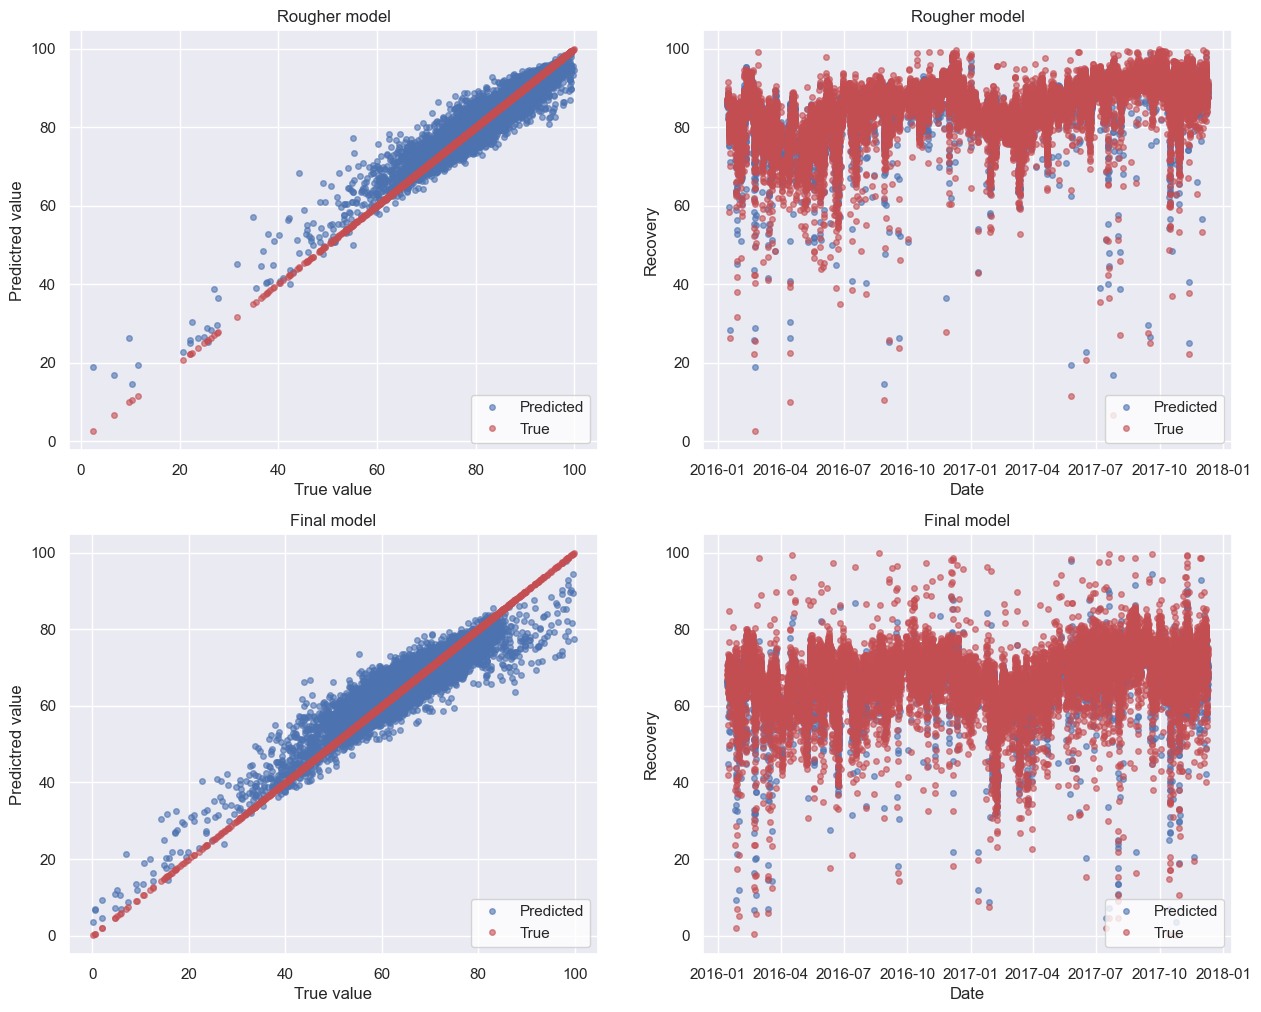

In [44]:
plt.figure(figsize=(15, 12))

plot_train_results(rougher_train['y'], cb_reg['rougher'].predict(rougher_train['X']), 'Rougher model', 2)
plot_train_results(final_train['y'], cb_reg['final'].predict(final_train['X']), 'Final model', 4)

In [45]:
# посчитаем sMAPE
cb_smape_rougher = symmetric_mape(rougher_train['y'], cb_reg['rougher'].predict(rougher_train['X']))
cb_smape_final = symmetric_mape(final_train['y'], cb_reg['final'].predict(final_train['X']))

cb_final_smape = final_smape(cb_smape_rougher, cb_smape_final)

In [46]:
# добавим в датафрейм для сравнения
f_smape_train.loc['CatBoost', :] = [cb_smape_rougher, cb_smape_final, cb_final_smape]
f_smape_train

,sMAPE черновой,sMAPE итоговый,final_sMAPE
Lasso,6.567390,9.198888,8.541013
Ridge,7.564229,11.011747,10.149867
LinReg,6.700761,9.515221,8.811606
CatBoost,2.176410,3.991961,3.538074


Градиентный бустинг показывает лучшие результаты, даже визуально на графиках.

## Нейронная сеть

Поиграемся немного с нейронной сетью. Создадим простейшую сеть, состоящую из линейных слоев с функциями активации ReLU.

In [48]:
class NN(nn.Module):
    def __init__(self, in_features):
        super().__init__()
    
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [49]:
def plot_losses(losses):
    """
    Построение изменений значений sMAPE при обучении нейросети
    
    Parameters:
    ----------
    losses: dict[list]
        значения sMAPE на разных этапах обучения
    """
    
    fig = plt.Figure()
    
    for loss_name, data in losses.items():
        plt.plot(range(1, len(data) + 1), data, '-', label=loss_name)

    plt.legend(facecolor='white')

    plt.title('Losses per epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.yscale('log')

    plt.show()

In [50]:
def train_net(net, optimizer, criterion, train_data, n_epochs=150):
    """
    Обучение нейронной сети.
    
    Parameters:
    ----------
    net: (nn.Model)
        нейронная сеть
    optimizer: torch.optim
        оптимизатор
    criterion: func
        функция потерь
    train_data: tuple[pd.DataFrame или pd.Series]
        обучающие данные
    n_epochs: int (default=200)
        число итераций обучения
    """
    
    y_train, X_train = train_data
    # y_test, X_test = test_data
        
    # переводим данные в тип tensor
    to_tensor = lambda x: torch.from_numpy(x.values).float().to(DEVICE)
    
    X_train = to_tensor(X_train)
    # X_test = to_tensor(X_test)
    y_train = to_tensor(y_train).view(-1, 1)
    
    losses = {'train': [], 'test': []}
    
    scheduler = ExponentialLR(optimizer, gamma=0.96)

    for epoch in range(n_epochs):
        net.train()

        optimizer.zero_grad()
        y_pred = net(X_train)

        loss = criterion(y_train, y_pred)
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses['train'].append(loss.cpu().detach().numpy())

        # net.eval()
        # y_pred = net(X_test)
        # loss = criterion(y_test, y_pred.view(-1).cpu().detach().numpy())

        # losses['test'].append(loss)

        clear_output(wait=True)
        plot_losses(losses)

In [51]:
torch.cuda.manual_seed_all(42)

In [52]:
# если есть возможность, будем обучаться на GPU
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# создадим модель для предсказания recovery чернового концентрата
rougher_net = NN(rougher_train['X'].shape[1]).to(DEVICE)
criterion = symmetric_mape
optimizer = torch.optim.Adam(rougher_net.parameters(), lr=0.001)

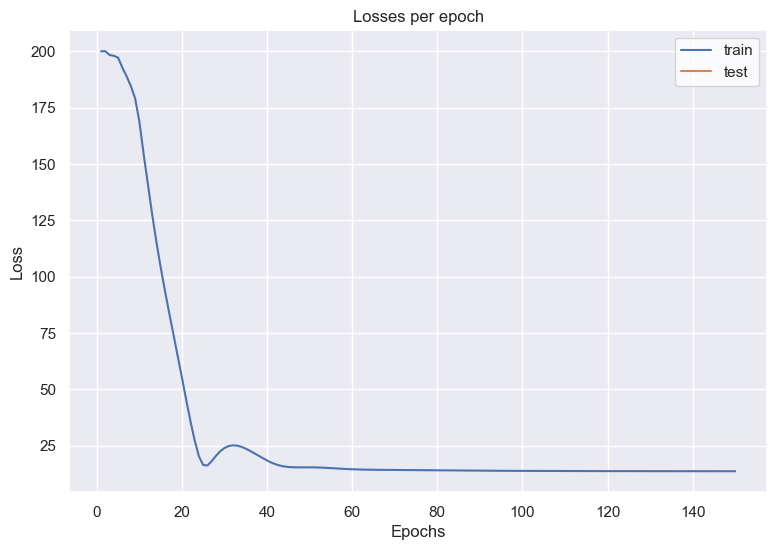

In [53]:
# обучаем
train_net(rougher_net, optimizer, criterion, 
          (y_train_rougher, X_train_rougher))

In [54]:
# создадим модель для предсказания recovery итогового концентрата
final_net = NN(final_train['X'].shape[1]).to(DEVICE)
criterion = symmetric_mape
optimizer = torch.optim.Adam(final_net.parameters(), lr=0.001)

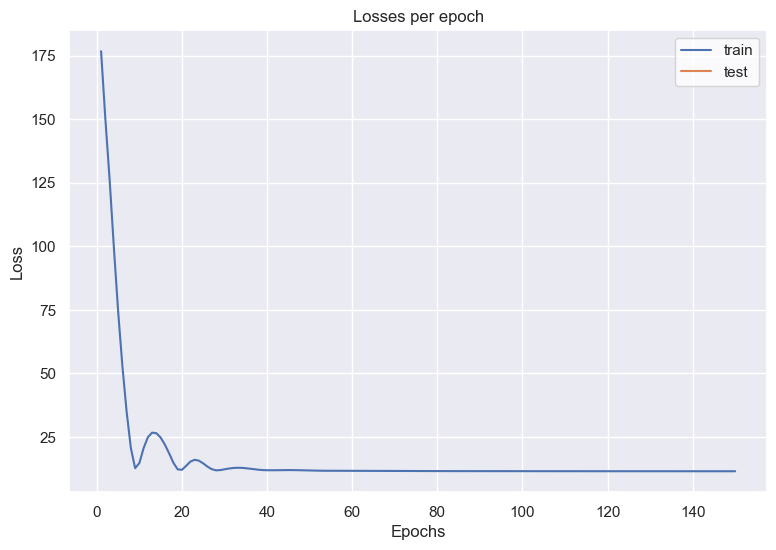

In [55]:
# обучаем
train_net(final_net, optimizer, criterion, 
          (y_train_final, X_train_final))

In [56]:
# возвращаем модели с cuda на cpu
rougher_net = rougher_net.to('cpu')
final_net = final_net.to('cpu')

In [57]:
# рассчитываем метрики на обучающих выборках
train_rougher_pred = rougher_net(torch.from_numpy(rougher_train['X'].values).float()).view(-1).detach().numpy()
train_final_pred = final_net(torch.from_numpy(final_train['X'].values).float()).view(-1).detach().numpy()

net_smape_rougher = symmetric_mape(rougher_train['y'], train_rougher_pred)
net_smape_final = symmetric_mape(final_train['y'], train_final_pred)
net_final_smape = final_smape(net_smape_rougher, net_smape_final)

f_smape_train.loc['Net', :] = [net_smape_rougher, net_smape_final, net_final_smape]
f_smape_train

,sMAPE черновой,sMAPE итоговый,final_sMAPE
Lasso,6.567390,9.198888,8.541013
Ridge,7.564229,11.011747,10.149867
LinReg,6.700761,9.515221,8.811606
CatBoost,2.176410,3.991961,3.538074
Net,8.461293,10.085515,9.679459


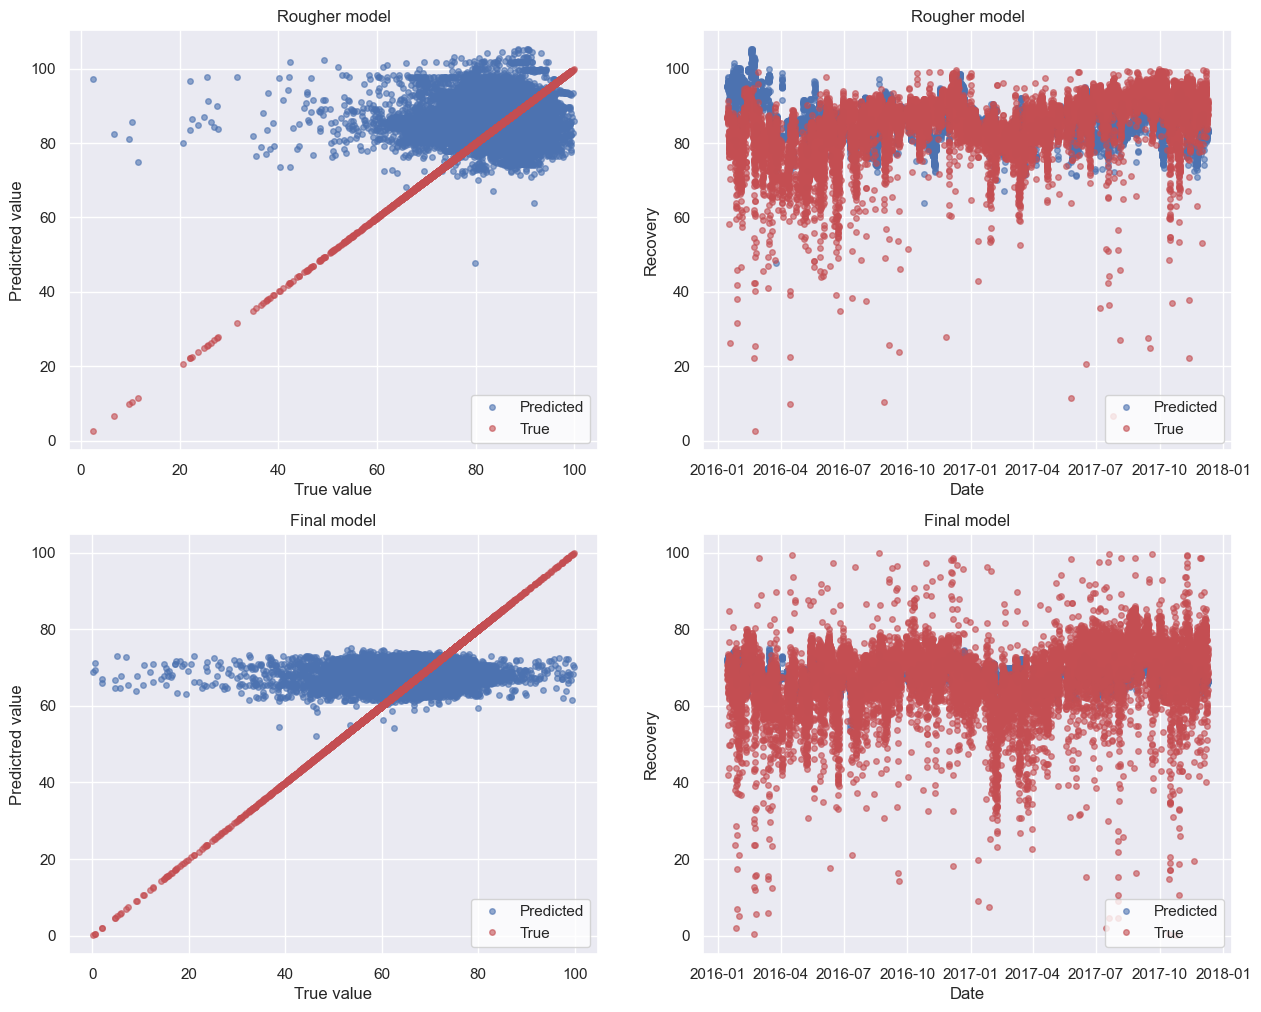

In [58]:
plt.figure(figsize=(15, 12))

plot_train_results(rougher_train['y'], train_rougher_pred, 'Rougher model', 2)
plot_train_results(final_train['y'], train_final_pred, 'Final model', 4)

Построить и обучить нормально сеть не получилось, модель оказалась наихудшей среди рассмотренных.

## Тестирование лучшей модели

Лучшей моделью у нас оказался градиентный бустинг. Посмотрим какие он даст результаты на тестовой выборке.

In [60]:
cb_smape_rougher = symmetric_mape(y_test_rougher, cb_reg['rougher'].predict(X_test_rougher))
cb_smape_final = symmetric_mape(y_test_final, cb_reg['final'].predict(X_test_final))

cb_final_smape = final_smape(cb_smape_rougher, cb_smape_final)

f_smape_test = pd.DataFrame(
    {
        'sMAPE черновой': cb_smape_rougher,
        'sMAPE итоговый': cb_smape_final,
        'final_sMAPE':    cb_final_smape
    },
    index=['CatBoost']
)

In [61]:
# сравним с константной моделью
for name, data in zip(['черновой', 'итоговый'], [(X_test_rougher, y_test_rougher), 
                                                 (X_test_final, y_test_final)]):
    dummy = DummyRegressor()
    dummy.fit(*data)
                   
    f_smape_test.loc['Dummy', f'sMAPE {name}'] = symmetric_mape(data[1], dummy.predict(data[0]))
    
f_smape_test.loc['Dummy', 'final_sMAPE'] = final_smape(
                                                          f_smape_test.loc['Dummy', 'sMAPE черновой'],
                                                          f_smape_test.loc['Dummy', 'sMAPE итоговый']
                                                      )
f_smape_test

,sMAPE черновой,sMAPE итоговый,final_sMAPE
CatBoost,3.021909,6.304265,5.483676
Dummy,5.896799,9.133313,8.324185


Модель показывает лучшие значения метрик, по сравнению с простой константной моделью. Отличный результат, можем ее использовать.

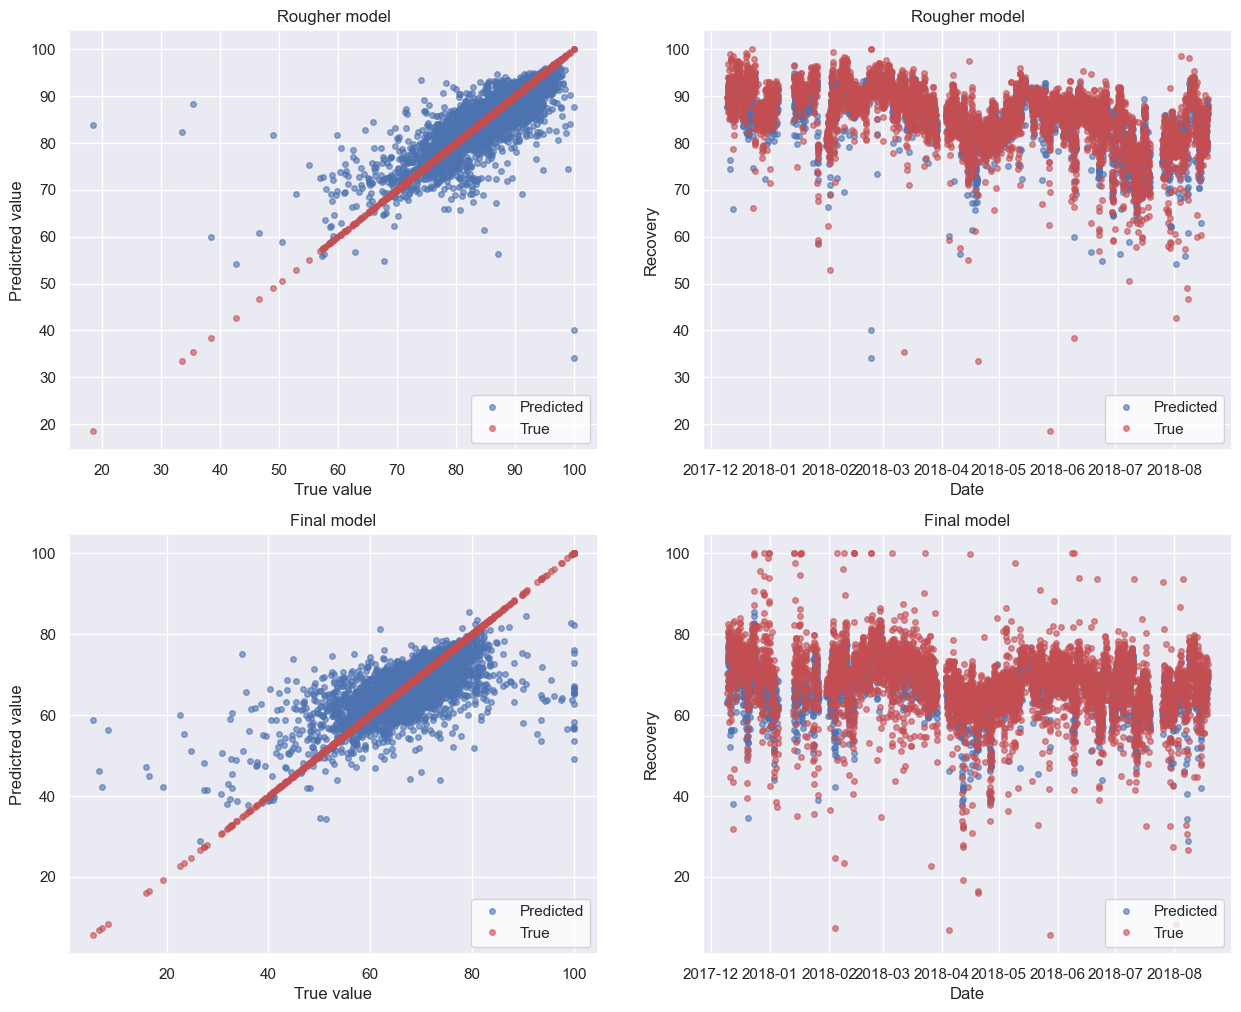

In [62]:
# построим графики для лучшей модели на тестовой выборке
plt.figure(figsize=(15, 12))

plot_train_results(y_test_rougher, cb_reg['rougher'].predict(X_test_rougher), 'Rougher model', 2)
plot_train_results(y_test_final,  cb_reg['final'].predict(X_test_final), 'Final model', 4)

Выглядит восхитительно.

# Вывод

Анализ данных показал, что:
- Все интересуюшие нас расчеты в представленных данных корректны;
- На каждом этапе (до и после флотации, две очистки)  относительная концентрация золота растет, причем зависимость строго линейная. Концентрация свинца также возрастает до второй очистки, после которой в финальном концентрате не изменяется. Более сложная зависимость у серебра: в черновом концентрате его доля возрастает, затем после первой очистки становится приблизительно равной изначальной доле и уменьшается в финальном концентрате;
- Распределения размеров гранул исходного сырья в обучающей и тестовой выборках схожи между собой, медианные значения отличаются незначительно;
- Суммарная относительная концентрация металлов растет с каждым этапом, разброс значений уменьшается;
- Распределения `recovery` на различных стадиях близки к нормальному со скосом влево. Эффективность обогащения после флотации выше, чем после всего процесса восстановления золота. Имеется большое число значений recovery, равных 0 или 100. В реальности вероятность получить подобные значения крайне мала, поэтому можно считать их за выбросы.

Пропуски в обучающих данных были заполнены при помощи интерполяции. Выбросы в 0 и 100 не учитывались при обучении моделей.
Всего было обучено 5 моделей. Лучше всего себя показал градиентный бустинг. Хуже всего нейронная сеть (кто-то не умеет их правильно строить и обучать). 

Сравнение итоговой модели с константной моделью показал ее адекватность.
